In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

#### Useful Functions

In [2]:
def create_dataset(dataset):
    data = pd.read_csv(dataset)
    return data

def check_missing_value(dataframe):
    return dataframe.isnull().sum()

def check_shape(dataframe):
    return dataframe.shape

def check_head(dataframe):
    return dataframe.head(5)

def check_tail(dataframe):
    return dataframe.tail(5)

def check_columns(dataframe):
    return dataframe.columns

def check_info(dataframe):
    return dataframe.info()

def check_dtypes(dataframe):
    return dataframe.dtypes

def check_values_counts(dataframe, x):
    return dataframe.value_counts(dropna = x)

In [3]:
train_df = create_dataset("train.csv")
test_df = create_dataset("test.csv")



In [4]:
check_head(train_df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
check_head(test_df)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(check_shape(train_df)))
print("The test data size before dropping Id feature is : {} ".format(check_shape(test_df)))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [7]:
## Get the id for both train and test before deleting
train_id = train_df["Id"]
test_id = test_df["Id"]


## drop the Id because we don't need them for modelling
train_df.drop("Id", axis = 1, inplace=True)
test_df.drop("Id", axis = 1, inplace=True)

# Check the numbers of samples and features
print("The train data size after dropping Id feature is : {} ".format(check_shape(train_df)))
print("The test data size after dropping Id feature is : {} ".format(check_shape(test_df)))

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


#### Analysing the target variable

In [8]:
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



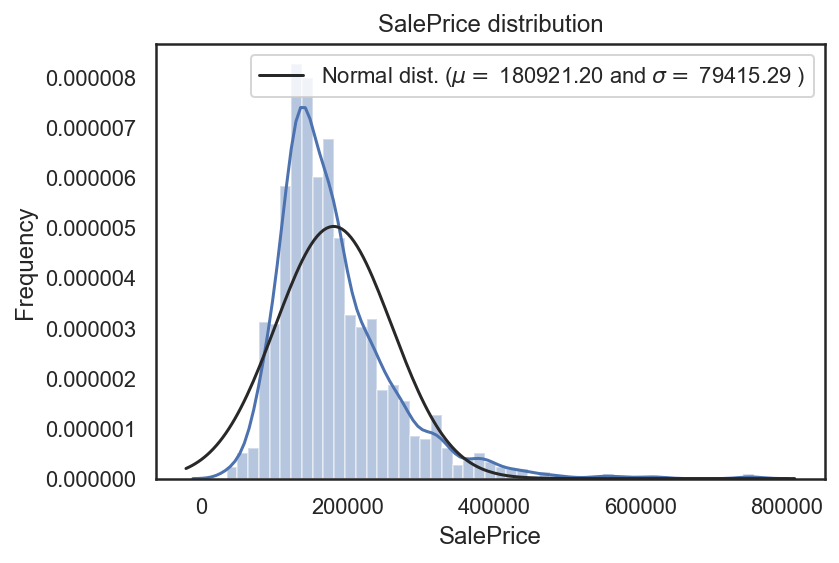

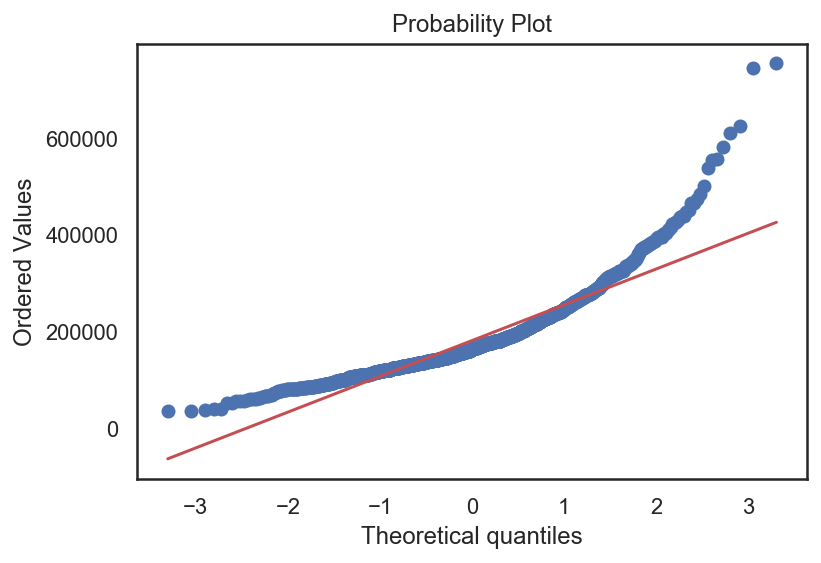

Skewness: 1.882876
Kurtosis: 6.536282


In [9]:
# sns.distplot(train_df["SalePrice"], color='r')
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

#### Obvious that the target variable is right skewed and not normal

In [10]:
# print(train_df["SalePrice"].kurtosis(), train_df["SalePrice"].skew())
pd.options.display.max_rows = None
pd.options.display.max_columns = None

#### Analysing the dataset

In [11]:
check_head(train_df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
#### Check the categorical data

cat = len(check_dtypes(train_df)[check_dtypes(train_df) == object])
#### There are 43 categorical features

#### Check the continous data
num = len(check_dtypes(train_df)[check_dtypes(train_df).isin(["int64", "float64"])])
#### There are 37 numeric data features


print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 3 numerical = 46 features


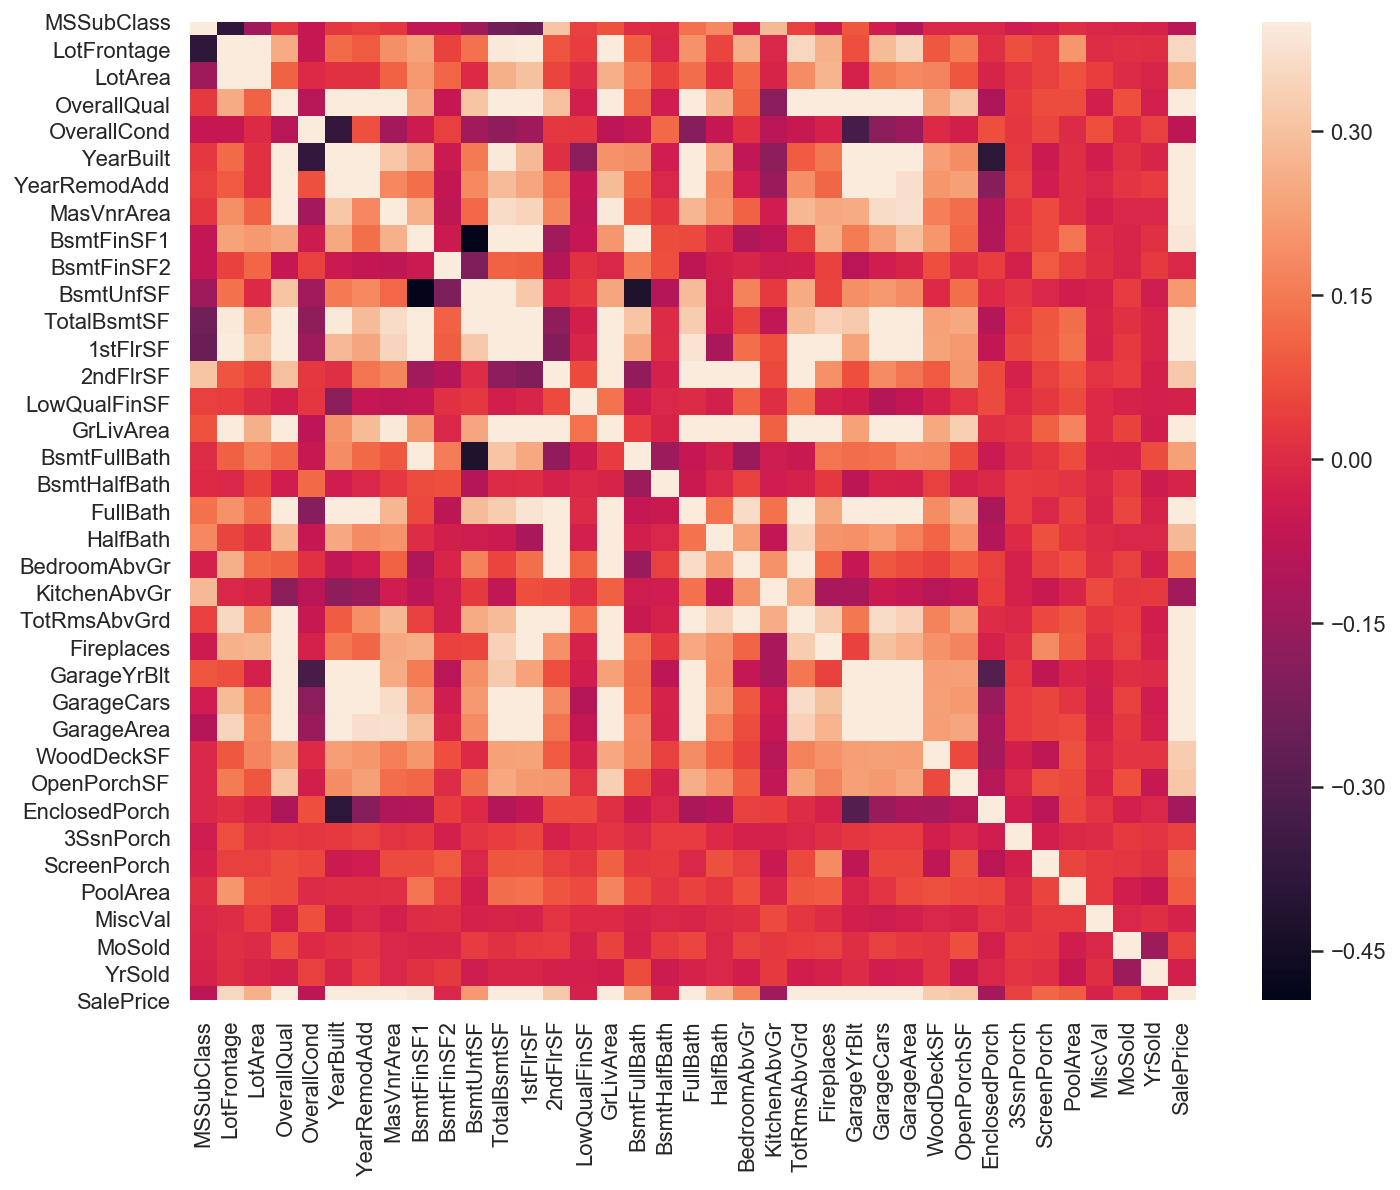

In [13]:
#### Check correlation
plt.figure(figsize=(12,9))
sns.heatmap(train_df.corr(), vmax=.4, square=True)

#### Check correlation of target variable with set of predictors

In [14]:
# Top 20 most correlated variables
k = 20 #number of variables for heatmap
cols = train_df.corr().nlargest(k, 'SalePrice')['SalePrice'].index

highly_correlated = pd.DataFrame(train_df.corr()["SalePrice"].sort_values(ascending=False).head(20)).reset_index()
highly_correlated.rename(columns = {"index": "Variable", "SalePrice": "Correlation_Value"}, inplace =  True)
highly_correlated

,Variable,Correlation_Value
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,GarageCars,0.640409
4,GarageArea,0.623431
5,TotalBsmtSF,0.613581
6,1stFlrSF,0.605852
7,FullBath,0.560664
8,TotRmsAbvGrd,0.533723
9,YearBuilt,0.522897


## Looking at each individual variable and how it relates with the target variable

In [15]:
def get_plot(variable):
    data = pd.concat([train_df["SalePrice"], train_df[variable]], axis =1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x =variable, y = "SalePrice", data = data)
    # plt.figure(figsize=(8, 6))
    fig.axis(ymin =0, ymax =800000)
    return fig


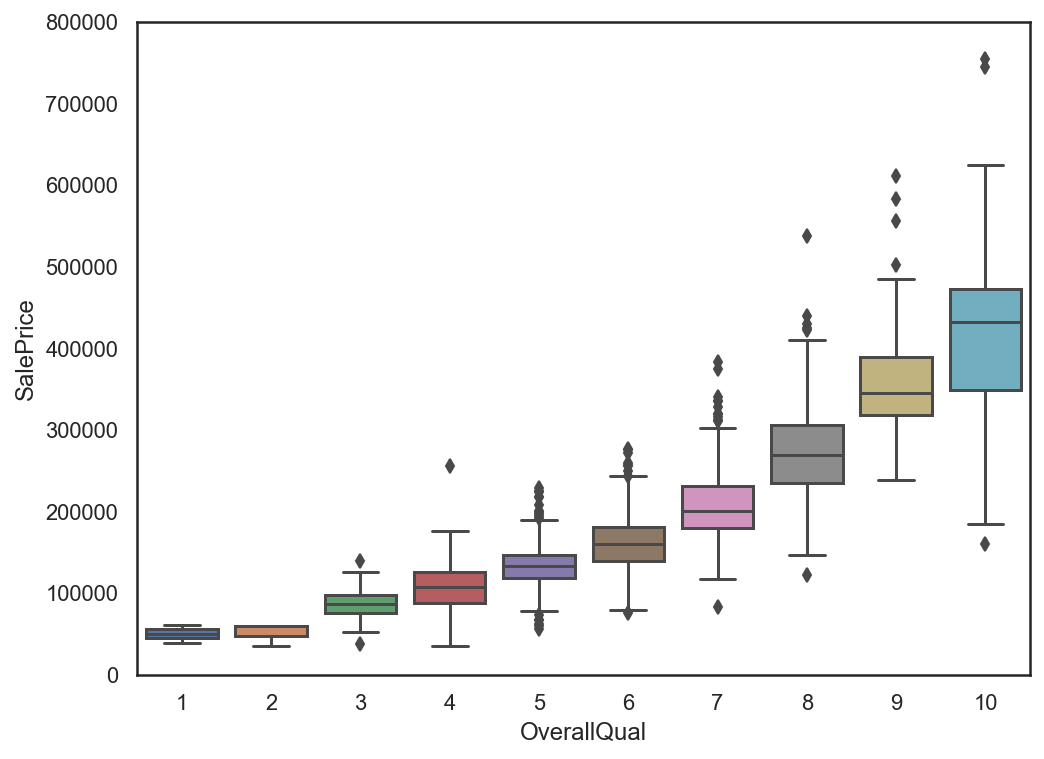

In [16]:
get_plot("OverallQual")
### Obviously, people pay more for quality houses

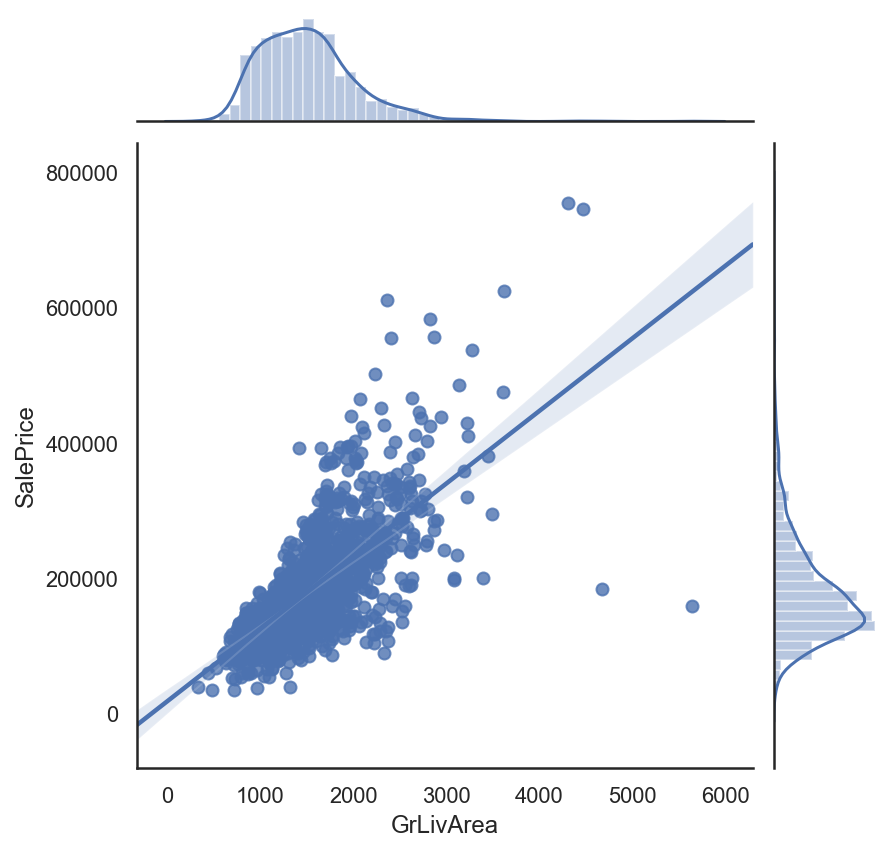

In [17]:
sns.jointplot(x = train_df["GrLivArea"], y = train_df["SalePrice"], kind = "reg")


In [18]:
## obviously, people will pay for the more living area. However, we can notice two outliers beneath the regression line.
## we'll try to remove the outliers.

train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) 
                         & (train_df['SalePrice']<300000)].index).reset_index(drop=True)

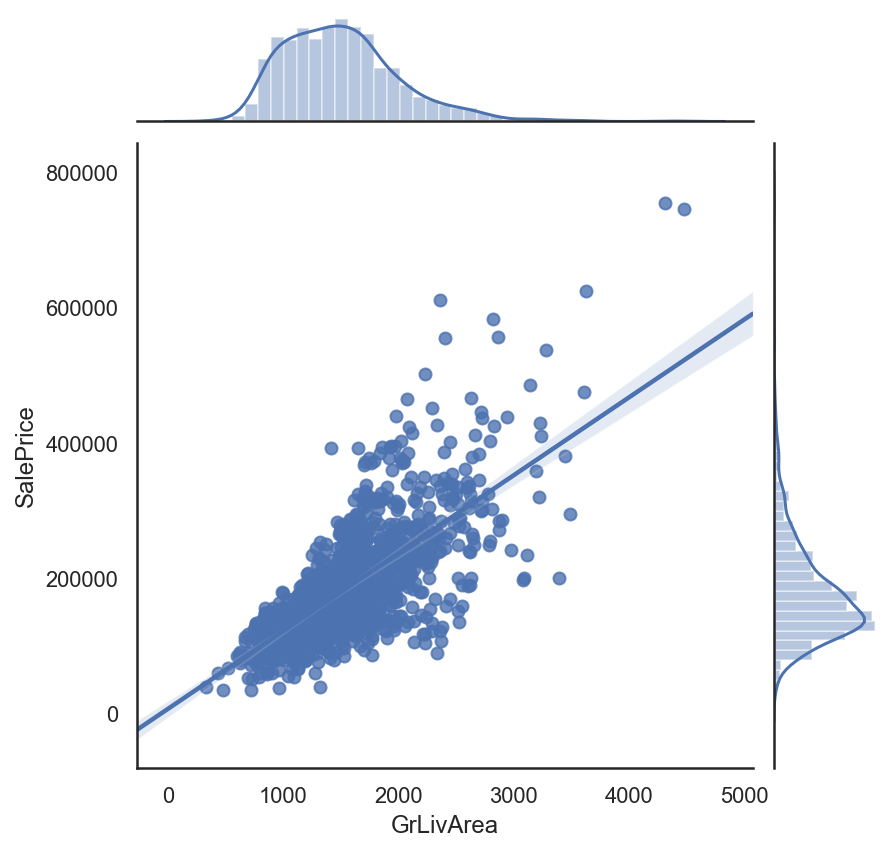

In [19]:
sns.jointplot(x = train_df["GrLivArea"], y = train_df["SalePrice"], kind = "reg")
## outlier now removed

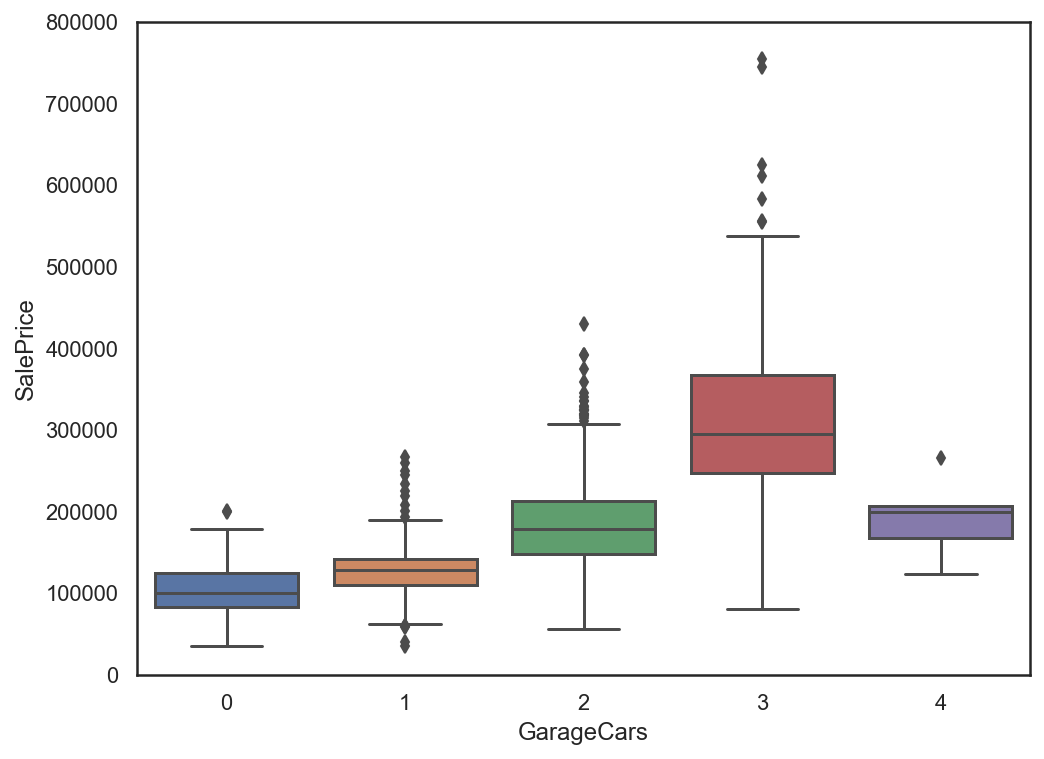

In [20]:
get_plot("GarageCars")
### Inconsistency in dataset. Houses with 4 GarageCars had less SalesPrice. We'll remove that outlier.

In [21]:
train_df = train_df.drop(train_df[(train_df['GarageCars']>3) 
                         & (train_df['SalePrice']<300000)].index).reset_index(drop=True)

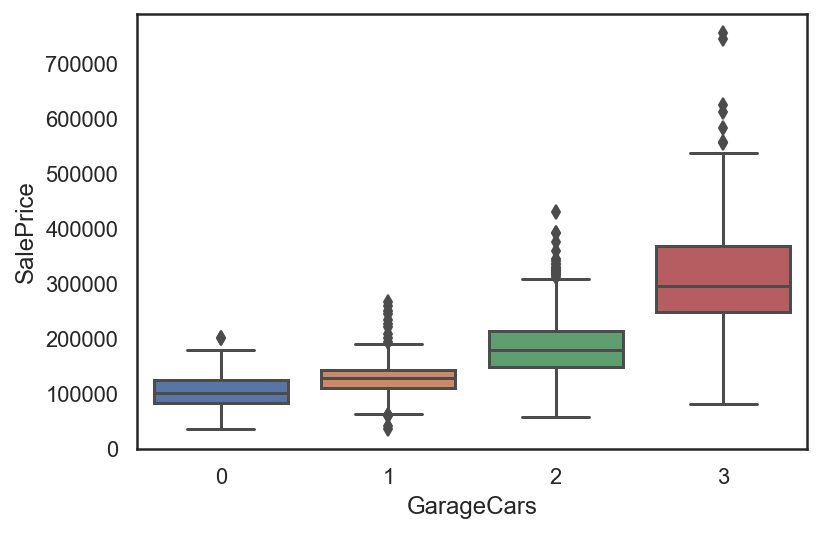

In [22]:
# Garage Area vs Sale Price
sns.boxplot(x=train_df['GarageCars'], y=train_df['SalePrice'])
### Outlier now removed

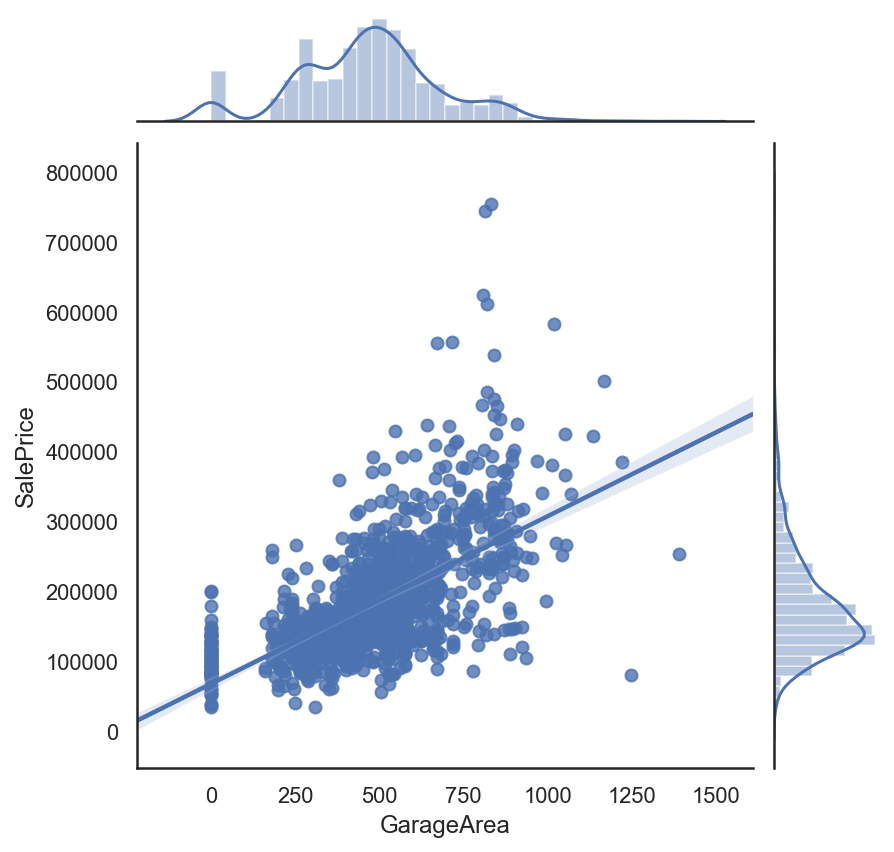

In [23]:
# Garage Area vs Sale Price
sns.jointplot(x=train_df['GarageArea'], y=train_df['SalePrice'], kind='reg')

## still has about two outliers that we'll remove

In [24]:
train_df = train_df.drop(train_df[(train_df['GarageArea']>1000) 
                         & (train_df['SalePrice']<300000)].index).reset_index(drop=True)

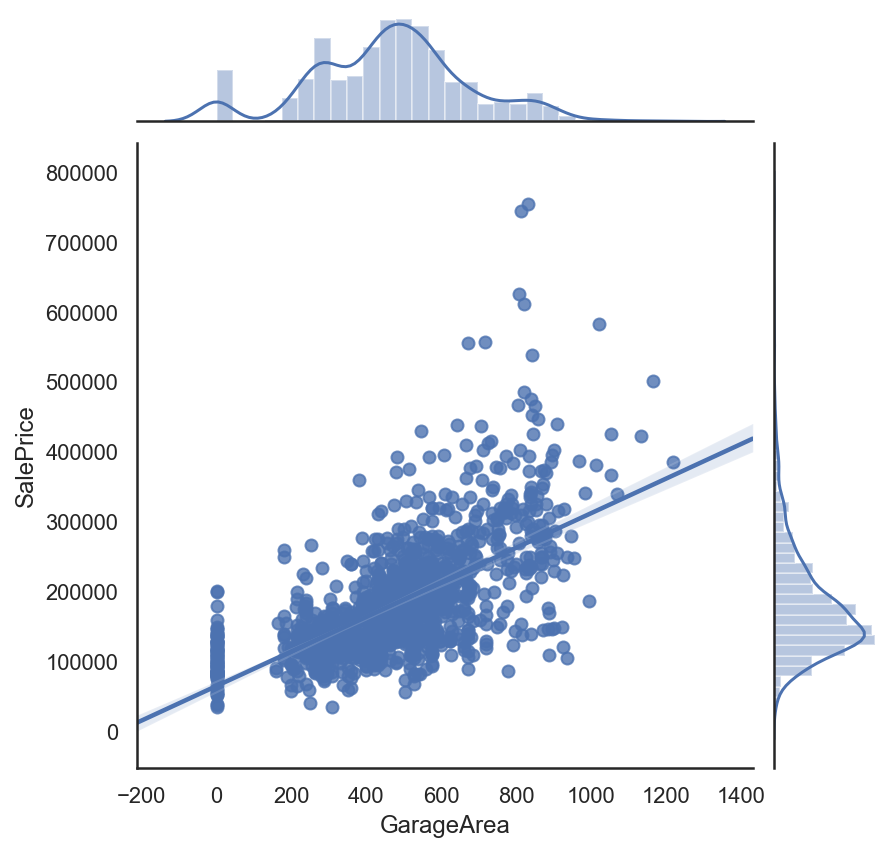

In [25]:
# Garage Area vs Sale Price
sns.jointplot(x=train_df['GarageArea'], y=train_df['SalePrice'], kind='reg')
## Looks better now

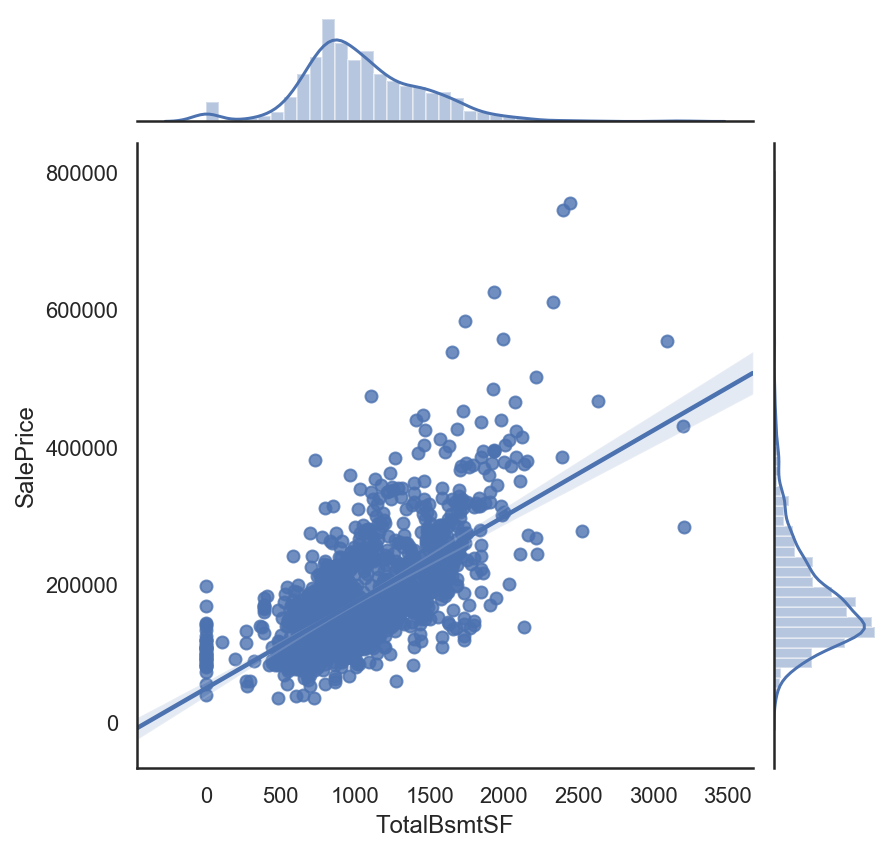

In [26]:
# Basement Area vs Sale Price
sns.jointplot(x=train_df['TotalBsmtSF'], y=train_df['SalePrice'], kind='reg')
## the data point looks good here.

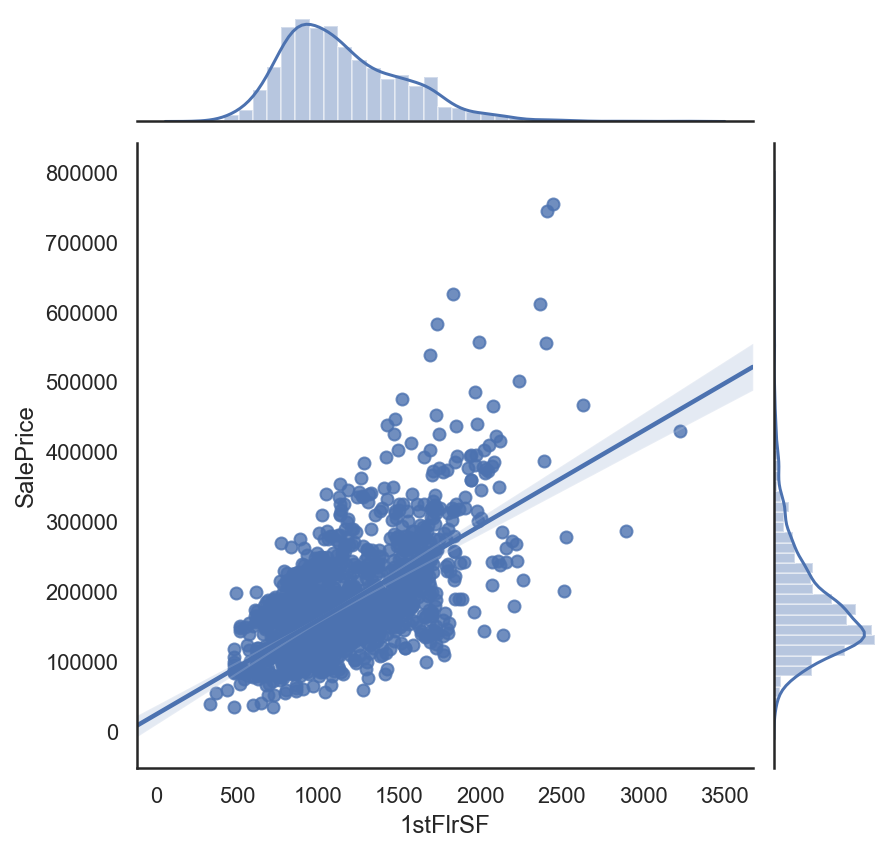

In [27]:
# First Floor Area vs Sale Price
sns.jointplot(x=train_df['1stFlrSF'], y=train_df['SalePrice'], kind='reg')
### Everthing looks good here too

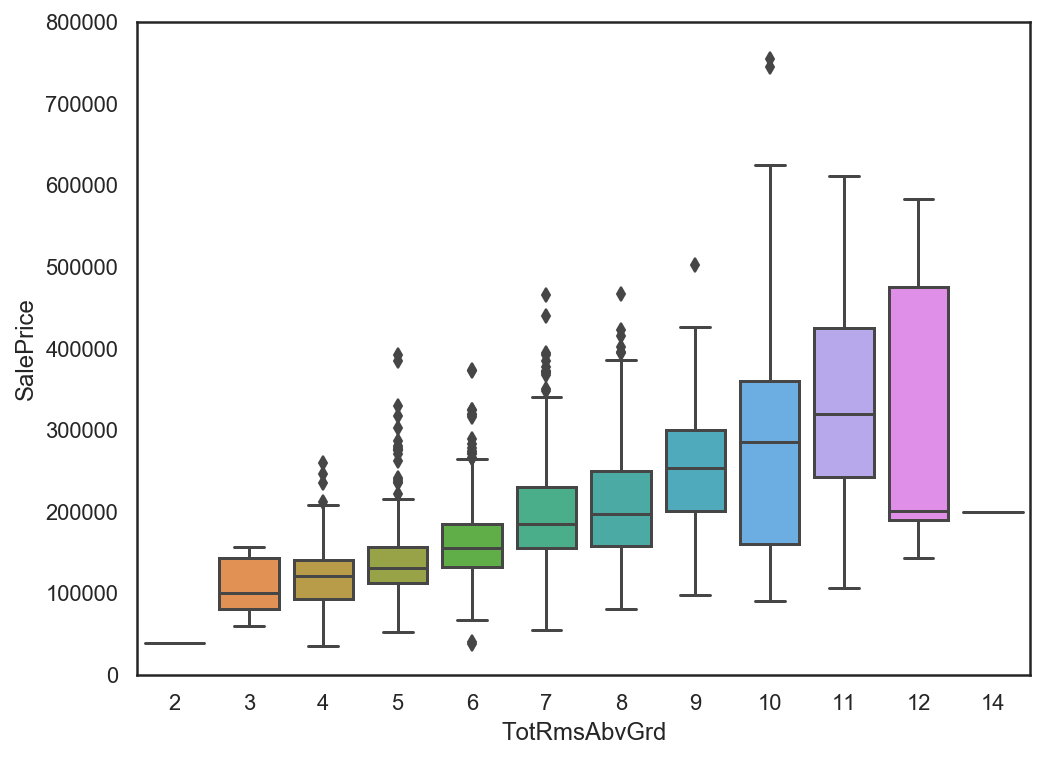

In [28]:
get_plot("TotRmsAbvGrd")
### things look good here

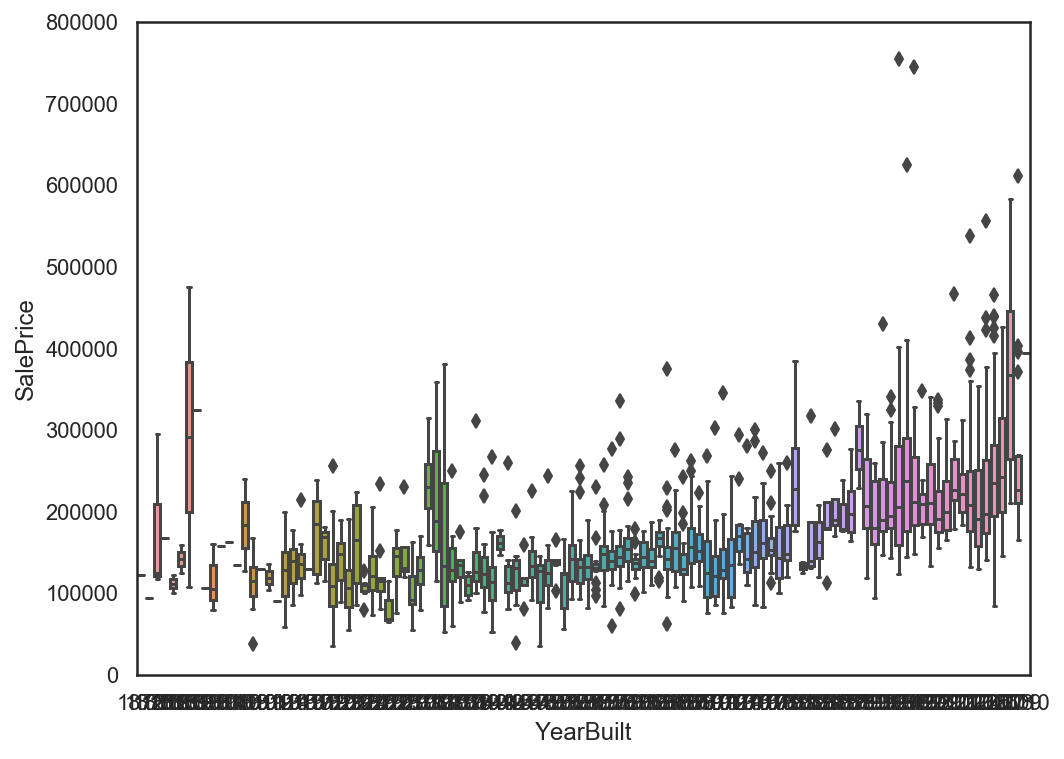

In [29]:
get_plot("YearBuilt")
### things look good here

#### Data Cleaning + Filling missing values

In [30]:
## Combine train and test
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df["SalePrice"]
full_data = pd.concat((train_df, test_df)).reset_index(drop=True)
full_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train_df.shape))
print("Test data size is : {}".format(test_df.shape))
print("Combined dataset size is : {}".format(full_data.shape))

Train data size is : (1448, 80)
Test data size is : (1459, 79)
Combined dataset size is : (2907, 79)


In [31]:
## Find percentage of missing data
missing_data = pd.DataFrame((full_data.isnull().sum() / len(full_data)) * 100).reset_index()
missing_data.rename(columns = {"index": "Variable", 0: "%Missing"}, inplace = True)
missing_data = missing_data[missing_data["%Missing"] != 0]
missing_data.reset_index(drop =True, inplace=True)
missing_data.sort_values(by = "%Missing", ascending = False, inplace= True)

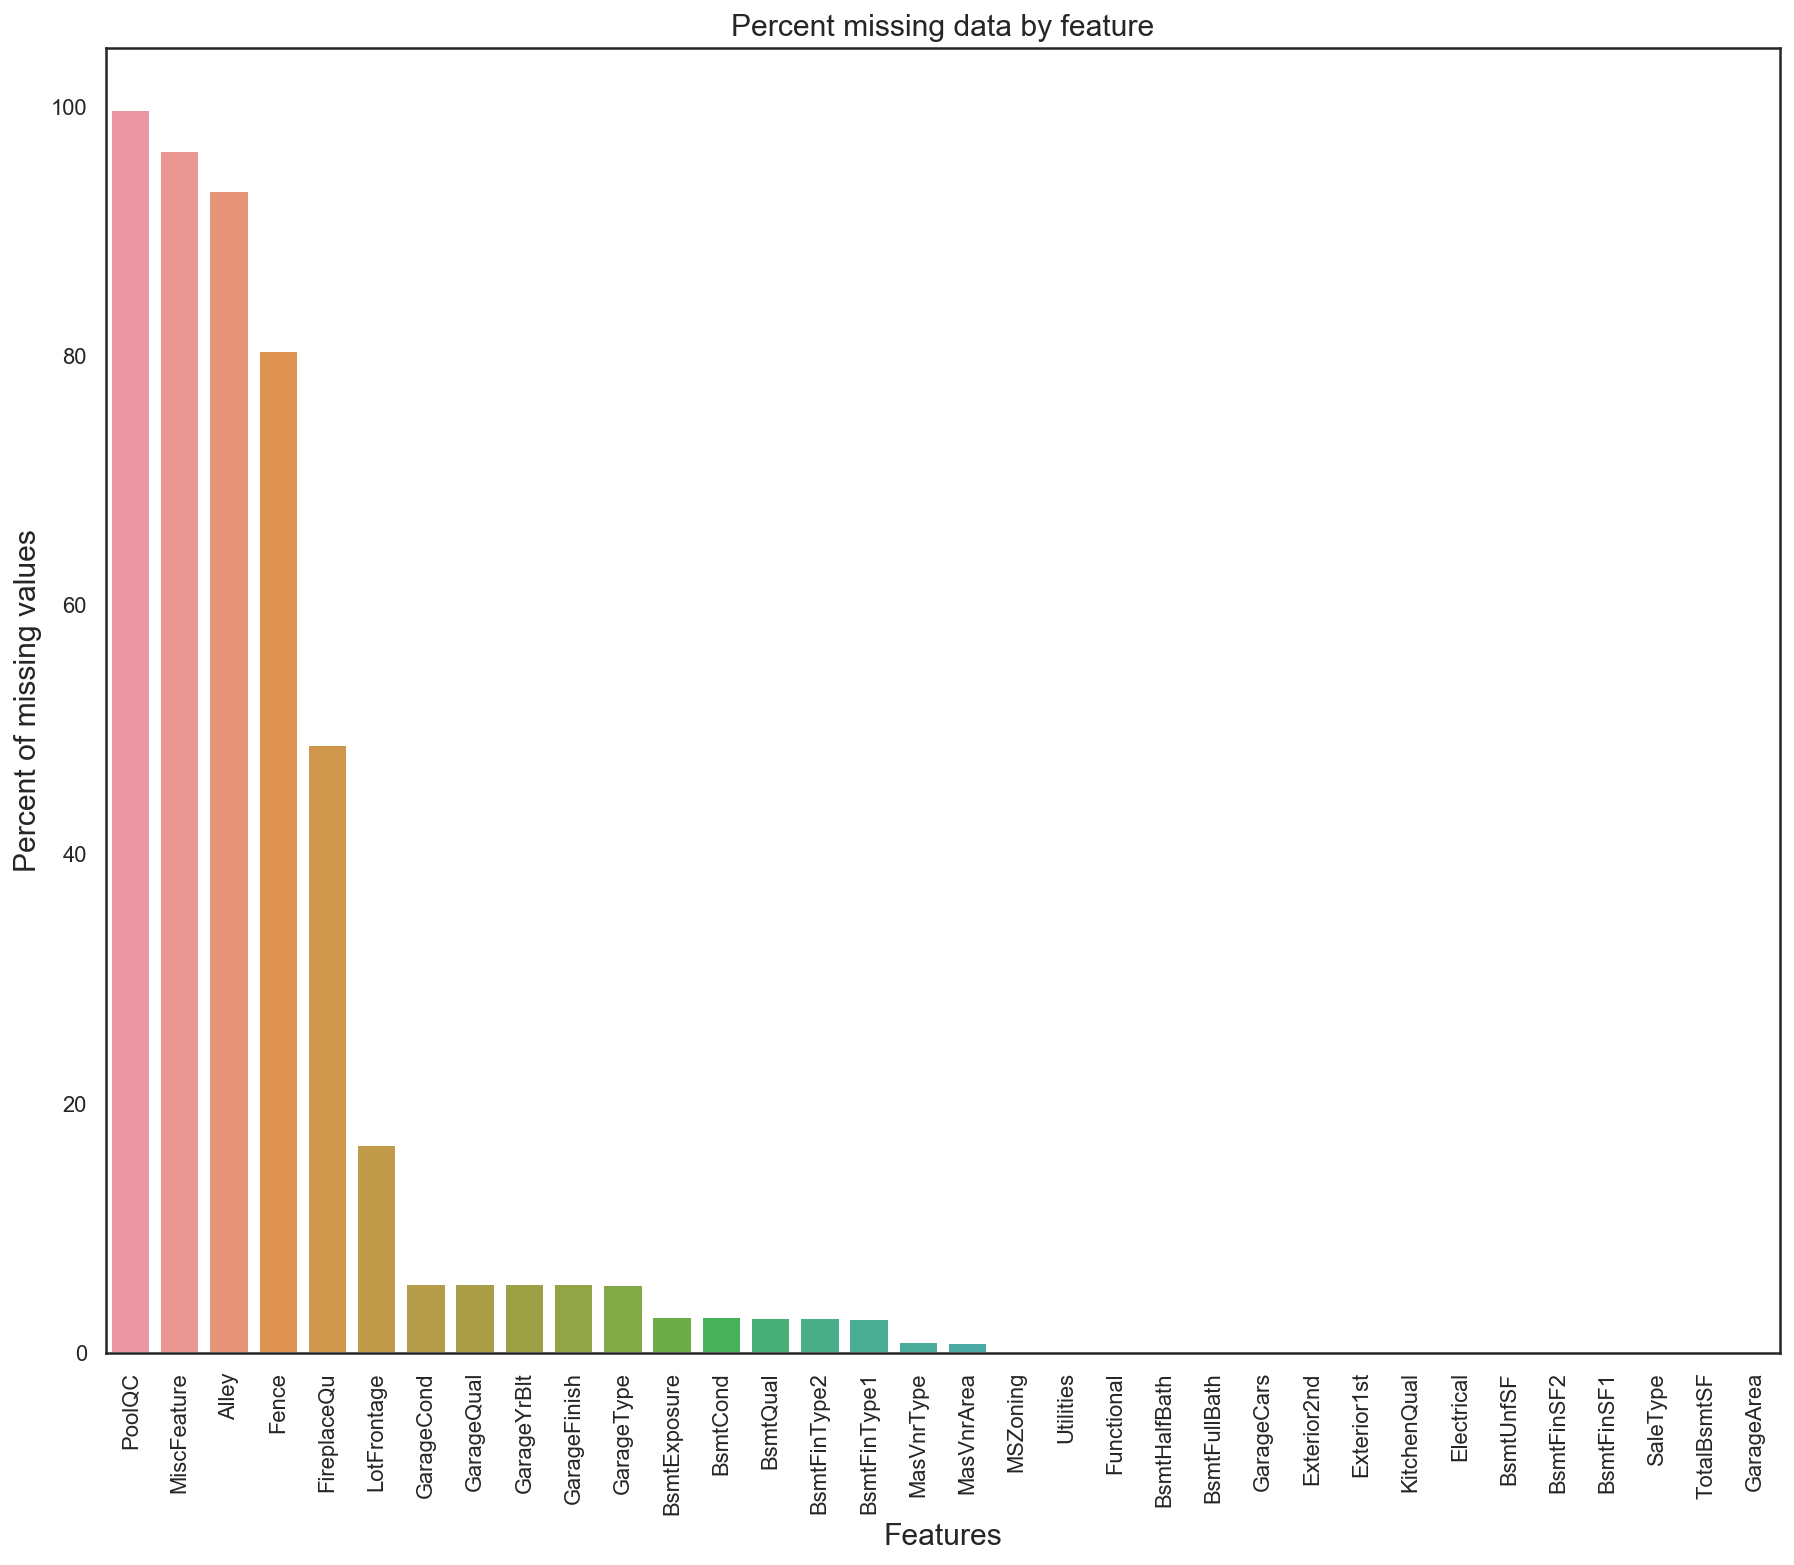

In [32]:
#### Get the plot
plt.figure(figsize=(15,12))
sns.barplot(x = missing_data["Variable"], y =  missing_data["%Missing"])
plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

### Filling in the missing values

In [33]:
full_data["PoolQC"] = full_data["PoolQC"].fillna("None")
full_data["MiscFeature"] = full_data["MiscFeature"].fillna("None")
full_data["Alley"] = full_data["Alley"].fillna("None")
full_data["Fence"] = full_data["Fence"].fillna("None")
full_data["FireplaceQu"] = full_data["FireplaceQu"].fillna("None")
full_data["LotFrontage"] = full_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    full_data[col] = full_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    full_data[col] = full_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    full_data[col] = full_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_data[col] = full_data[col].fillna('None')
    
full_data["MasVnrType"] = full_data["MasVnrType"].fillna("None")
full_data["MasVnrArea"] = full_data["MasVnrArea"].fillna(0)
full_data['MSZoning'] = full_data['MSZoning'].fillna(full_data['MSZoning'].mode()[0])
full_data = full_data.drop(['Utilities'], axis=1)
full_data["Functional"] = full_data["Functional"].fillna("Typ")
full_data['Electrical'] = full_data['Electrical'].fillna(full_data['Electrical'].mode()[0])
full_data['KitchenQual'] = full_data['KitchenQual'].fillna(full_data['KitchenQual'].mode()[0])
full_data['Exterior1st'] = full_data['Exterior1st'].fillna(full_data['Exterior1st'].mode()[0])
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna(full_data['Exterior2nd'].mode()[0])
full_data['SaleType'] = full_data['SaleType'].fillna(full_data['SaleType'].mode()[0])
full_data['MSSubClass'] = full_data['MSSubClass'].fillna("None")


In [34]:
#### All missing values handled
full_data.isnull().sum()

1stFlrSF         0
2ndFlrSF         0
3SsnPorch        0
Alley            0
BedroomAbvGr     0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtFinType1     0
BsmtFinType2     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtQual         0
BsmtUnfSF        0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
EnclosedPorch    0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Fireplaces       0
Foundation       0
FullBath         0
Functional       0
GarageArea       0
GarageCars       0
GarageCond       0
GarageFinish     0
GarageQual       0
GarageType       0
GarageYrBlt      0
GrLivArea        0
HalfBath         0
Heating          0
HeatingQC        0
HouseStyle       0
KitchenAbvGr     0
KitchenQual      0
LandContour      0
LandSlope        0
LotArea          0
LotConfig        0
LotFrontage      0
LotShape         0
LowQualFinSF     0
MSSubClass  

#### Feature Engineering/Transformation

In [35]:
check_dtypes(full_data)

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
Functional        object
GarageArea       float64
GarageCars       float64
GarageCond        object
GarageFinish      object
GarageQual        object
GarageType        object
GarageYrBlt      float64
GrLivArea          int64
HalfBath           int64


In [36]:
check_head(full_data)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,None,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,None,0,2,CollgCr,61,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,None,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,None,0,5,Veenker,0,8,6,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,None,0,9,CollgCr,42,5,7,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,None,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,None,0,2,Crawfor,35,5,7,Y,0,None,CompShg,Gable,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,None,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,None,0,12,NoRidge,84,5,8,Y,0,None,CompShg,Gable,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [37]:
# the MSSubClass and OverallCond variable is meant to be a categorical variable and not numeric
full_data["MSSubClass"] = full_data["MSSubClass"].astype(str)

#Changing OverallCond into a categorical variable
full_data['OverallCond'] = full_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
full_data['YrSold'] = full_data['YrSold'].astype(str)
full_data['MoSold'] = full_data['MoSold'].astype(str)

In [38]:
check_dtypes(full_data)
## All corrected

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
Alley             object
BedroomAbvGr       int64
BldgType          object
BsmtCond          object
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1      object
BsmtFinType2      object
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual          object
BsmtUnfSF        float64
CentralAir        object
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch      int64
ExterCond         object
ExterQual         object
Exterior1st       object
Exterior2nd       object
Fence             object
FireplaceQu       object
Fireplaces         int64
Foundation        object
FullBath           int64
Functional        object
GarageArea       float64
GarageCars       float64
GarageCond        object
GarageFinish      object
GarageQual        object
GarageType        object
GarageYrBlt      float64
GrLivArea          int64
HalfBath           int64


In [39]:
## Label Encoding
from sklearn.preprocessing import LabelEncoder

cat_columns = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

## Applying the label encoder 
for variables in cat_columns:
    lbl = LabelEncoder() 
    lbl.fit(list(full_data[variables].values)) 
    full_data[variables] = lbl.transform(list(full_data[variables].values))


In [40]:
check_head(full_data)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,2,6,1.0,0.0,2,150.0,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,3,0,PConc,2,6,548.0,2.0,5,2,5,Attchd,2003.0,1710,1,GasA,0,2Story,1,2,Lvl,0,8450,Inside,65.0,3,0,10,RL,196.0,BrkFace,None,0,4,CollgCr,61,4,7,2,0,3,CompShg,Gable,Normal,WD,0,1,8,856.0,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,0,6,0.0,1.0,2,284.0,1,Feedr,Norm,SBrkr,0,4,3,MetalSd,MetalSd,4,5,1,CBlock,2,6,460.0,2.0,5,2,5,Attchd,1976.0,1262,0,GasA,0,1Story,1,3,Lvl,0,9600,FR2,80.0,3,0,5,RL,0.0,None,None,0,7,Veenker,0,7,6,2,0,3,CompShg,Gable,Normal,WD,0,1,6,1262.0,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,2,6,1.0,0.0,2,434.0,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,5,1,PConc,2,6,608.0,2.0,5,2,5,Attchd,2001.0,1786,1,GasA,0,2Story,1,2,Lvl,0,11250,Inside,68.0,0,0,10,RL,162.0,BrkFace,None,0,11,CollgCr,42,4,7,2,0,3,CompShg,Gable,Normal,WD,0,1,6,920.0,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,0,6,1.0,0.0,4,540.0,1,Norm,Norm,SBrkr,272,4,3,Wd Sdng,Wd Shng,4,2,1,BrkTil,1,6,642.0,3.0,5,3,5,Detchd,1998.0,1717,0,GasA,2,2Story,1,2,Lvl,0,9550,Corner,60.0,0,0,11,RL,0.0,None,None,0,4,Crawfor,35,4,7,2,0,3,CompShg,Gable,Abnorml,WD,0,1,7,756.0,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,2,6,1.0,0.0,2,490.0,1,Norm,Norm,SBrkr,0,4,2,VinylSd,VinylSd,4,5,1,PConc,2,6,836.0,3.0,5,2,5,Attchd,2000.0,2198,1,GasA,0,2Story,1,2,Lvl,0,14260,FR2,84.0,0,0,10,RL,350.0,BrkFace,None,0,3,NoRidge,84,4,8,2,0,3,CompShg,Gable,Normal,WD,0,1,9,1145.0,192,2000,2000,2


In [41]:
## Check shape of datashape
# Check shape        
print('Shape all_data: {}'.format(check_shape(full_data)))

Shape all_data: (2907, 78)


In [42]:
### Engineering a new feature gotten by adding Total Square Feet feature 
full_data['TotalSF'] = full_data['TotalBsmtSF'] + full_data['1stFlrSF'] + full_data['2ndFlrSF']

#### Trying to fix the skew issue in the target variable



 mu = 12.02 and sigma = 0.40



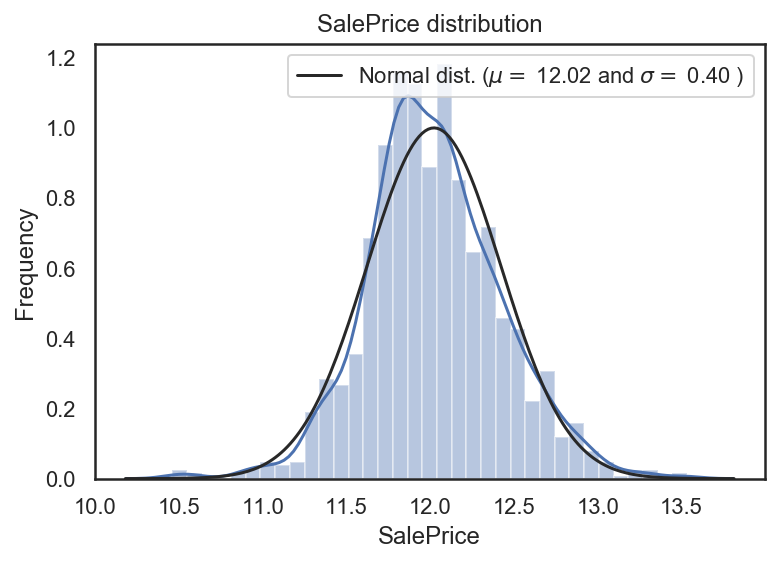

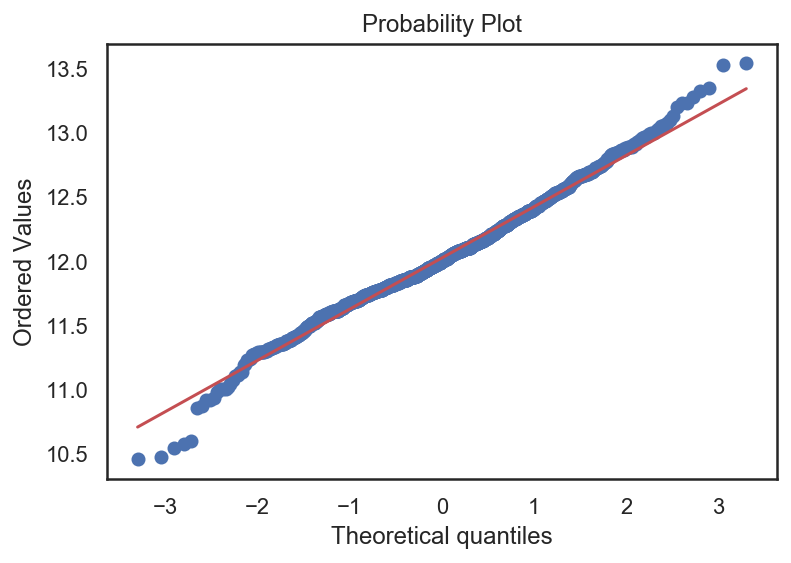

Skewness: 0.130172
Kurtosis: 0.822862


In [43]:
## We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

y_train = train_df.SalePrice.values

print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

In [44]:
pd.DataFrame(y_train, columns=["Log Transformed"]).head()

,Log Transformed
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220


In [45]:
#### Check the skewness of all numeric variables

numberical_feature = full_data.dtypes[full_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = full_data[numberical_feature].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})

skewness.head()


,Skewed Features
MiscVal,21.911765
PoolArea,17.658029
LotArea,13.147728
LowQualFinSF,12.063406
3SsnPorch,11.352135


In [46]:
### here, we'll use a transformation function: Box Cox transform to transform the variables

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_data[feat] = boxcox1p(full_data[feat], lam)
    full_data[feat] += 1

There are 59 skewed numerical features to Box Cox transform


In [47]:
print("{} is the shape before applying dummies".format(check_shape(full_data)))
### Now we applied the get dummies method
full_data = pd.get_dummies(full_data)

print("{} is the shape after applying dummies".format(check_shape(full_data)))


(2907, 79) is the shape before applying dummies
(2907, 220) is the shape after applying dummies


In [48]:
check_head(full_data)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,EnclosedPorch,ExterCond,ExterQual,Fence,FireplaceQu,Fireplaces,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GrLivArea,HalfBath,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotArea,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,12.692623,12.686189,1.0,1.730463,2.540963,2.820334,2.540963,12.170327,1.0,2.194318,3.259674,1.730463,1.000000,2.194318,8.483296,1.730463,1.000000,2.820334,2.194318,2.820334,2.540963,1.000000,2.194318,3.259674,11.506271,2.194318,3.055642,2.194318,3.055642,15.187527,14.698888,1.730463,1.000000,1.730463,2.194318,1.0,20.212182,6.831328,2.540963,1.0,3.885846,9.059126,1.0,2.820334,6.714669,2.820334,3.440268,2.194318,1.0,2.540963,1.0,1.730463,3.602594,12.692623,1.000000,15.187527,15.187527,2.194318,15.976591,1,0,0,0,0,0,0,1,0,0,0,0,0,0

In [207]:
### Seperate train and test
train = full_data[:ntrain]
test = full_data[ntrain:]

#### Join Train and target variable and then find the correlation

In [208]:
# target = pd.DataFrame(y_train, columns = ["SalePrice"] )

In [209]:
# full_train = pd.concat([train, target], axis=1)

In [210]:
# def find_stability(feature_list):
#     positive = 0
#     negative = 0
#     for i in feature_list:
        
#         if i > 0:
#             positive += 1
#         else:
#             negative += 1
    
#     abs_corr =  [abs(element) for element in feature_list] 
    
#     return (max(positive, negative),(sum(abs_corr)/len(abs_corr)))

In [211]:
# def find_stable_features(data, splits=4, direction_count=8, avg_corr=0.1):
    
#     df_split_ordered = np.array_split(data.sort_values(by = "YrSold"), splits)
#     df_split = np.array_split(data, splits)

#     combined = df_split_ordered + df_split

#     corr_df = pd.DataFrame()
    
#     for index, df in enumerate(combined):
#         corr_df[f'split_{index}'] = df.corr()["SalePrice"]

#     direction = corr_df.apply(lambda x : find_stability(x),axis=1)

#     corr_df["direction"] = direction.apply(lambda x : x[0])
#     corr_df["average_corr"] = direction.apply(lambda x : x[1])

#     set_direction = set(corr_df[corr_df["direction"] >= direction_count].index)
#     set_average_corr = set(corr_df[corr_df["average_corr"] >= avg_corr].index)

#     stable_features = list(set_direction.intersection(set_average_corr))
    
#     return stable_features

In [212]:
# model_1_variable_corr = dict(full_train.corr()["SalePrice"])

In [213]:
# model_1_stable_features = find_stable_features(full_train, direction_count=4)
# print (len(model_1_stable_features))

# new_dict = {x: v for x, v in model_1_variable_corr.items() if x in model_1_stable_features}
# print(new_dict)

In [214]:
# selected_cols = list(new_dict.keys())

In [215]:
# train = full_train.loc[:, selected_cols].drop("SalePrice", axis =1)
# y_train = full_train["SalePrice"]

In [216]:
## now we have train, y_train and test. It's time to build a model

#### Building Model and Making Predictions

In [281]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [317]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



In [320]:
# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_lgb)

# print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [292]:
def cv_rmse(model, X=train, y=y_train):    
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))

In [293]:
# from sklearn.linear_model import RidgeCV 
# import lightgbm as lgb
# K = 10
# from mlxtend.regressor import StackingCVRegressor
# import datetime

# SEED = 10
# kf = KFold(n_splits=K, shuffle=True, random_state=SEED)
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=np.arange(14.5, 15.6, 0.1), cv=kf))
# lasso = make_pipeline(RobustScaler(), LassoCV(alphas=np.arange(0.0001, 0.0009, 0.0001), random_state=SEED, cv=kf))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(alphas=np.arange(0.0001, 0.0008, 0.0001), l1_ratio=np.arange(0.8, 1, 0.025), cv=kf))
# svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=SEED)
# lgbmr = lgb.LGBMRegressor(objective='regression', 
#                       num_leaves=4,
#                       learning_rate=0.01, 
#                       n_estimators=5000,
#                       max_bin=200, 
#                       bagging_fraction=0.75,
#                       bagging_freq=5, 
#                       bagging_seed=SEED,
#                       feature_fraction=0.2,
#                       feature_fraction_seed=SEED,
#                       verbose=0)
# xgbr = xgb.XGBRegressor(learning_rate=0.01,
#                     n_estimators=3500,
#                     max_depth=3,
#                     gamma=0.001,
#                     subsample=0.7,
#                     colsample_bytree=0.7,
#                     objective='reg:squarederror',
#                     nthread=-1,
#                     seed=SEED,
#                     reg_alpha=0.0001)
# stack = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, svr, gbr, lgbmr, xgbr), meta_regressor=xgbr, use_features_in_secondary=True)

# models = {'RidgeCV': ridge,
#           'LassoCV': lasso, 
#           'ElasticNetCV': elasticnet,
#           'SupportVectorRegressor': svr, 
#           'GradientBoostingRegressor': gbr, 
#           'LightGBMRegressor': lgbmr, 
#           'XGBoostRegressor': xgbr, 
#           'StackingCVRegressor': stack}
# predictions = {}
# scores = {}

# for name, model in models.items():
# #     start = datetime.now()
# #     print('[{}] Running {}'.format(start, name))
    
#     model.fit(train, y_train)
#     predictions[name] = np.expm1(model.predict(train))
    
#     score = cv_rmse(model, X=train, y=y_train)
#     scores[name] = (score.mean(), score.std())
    
# #     end = datetime.now()
    
# #     print('[{}] Finished Running {} in {:.2f}s'.format(end, name, (end - start).total_seconds()))
# #     print('[{}] {} Mean RMSE: {:.6f} / Std: {:.6f}\n'.format(name, scores[name][0], scores[name][1]))


In [294]:
LassoMd = lasso.fit(train,y_train)
ENetMd = ENet.fit(train,y_train)
KRRMd = KRR.fit(train,y_train)
GBoostMd = GBoost.fit(train,y_train)
XG = model_xgb.fit(train,y_train)
LGB = model_lgb.fit(train,y_train)



In [295]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [296]:
# seven_predict = (LassoMd.predict(train) + ENetMd.predict(train) + KRRMd.predict(train) + GBoostMd.predict(train) + 
#                XG.predict(train) + LGB.predict(train) + RF.predict(train))/7
# rmsle(y_train, seven_predict)

In [316]:
six_predict = (LassoMd.predict(train) + ENetMd.predict(train) + KRRMd.predict(train) + GBoostMd.predict(train) + 
               XG.predict(train) + LGB.predict(train))/6
rmsle(y_train, six_predict)

0.06988128400251417

In [300]:
# XG = model_xgb.fit(train,y_train)
# XG_pred = XG.predict(train)
# rmsle(y_train, XG_pred)

In [301]:
training_data = np.expm1(y_train)

train_model = np.expm1(six_predict)


a = pd.DataFrame(training_data).reset_index().drop("index", axis =1)
a.columns = ["actual"]

b = pd.DataFrame(train_model, columns = ["prediction"]).reset_index().drop("index", axis =1)


result_training_set= pd.concat([a,b], axis =1)
result_training_set["difference"] = abs(result_training_set["actual"] - result_training_set["prediction"])

In [302]:
result_training_set.head()

,actual,prediction,difference
0,208500.0,207116.799932,1383.200068
1,181500.0,181228.829734,271.170266
2,223500.0,217318.952392,6181.047608
3,140000.0,155245.535199,15245.535199
4,250000.0,282451.278959,32451.278959


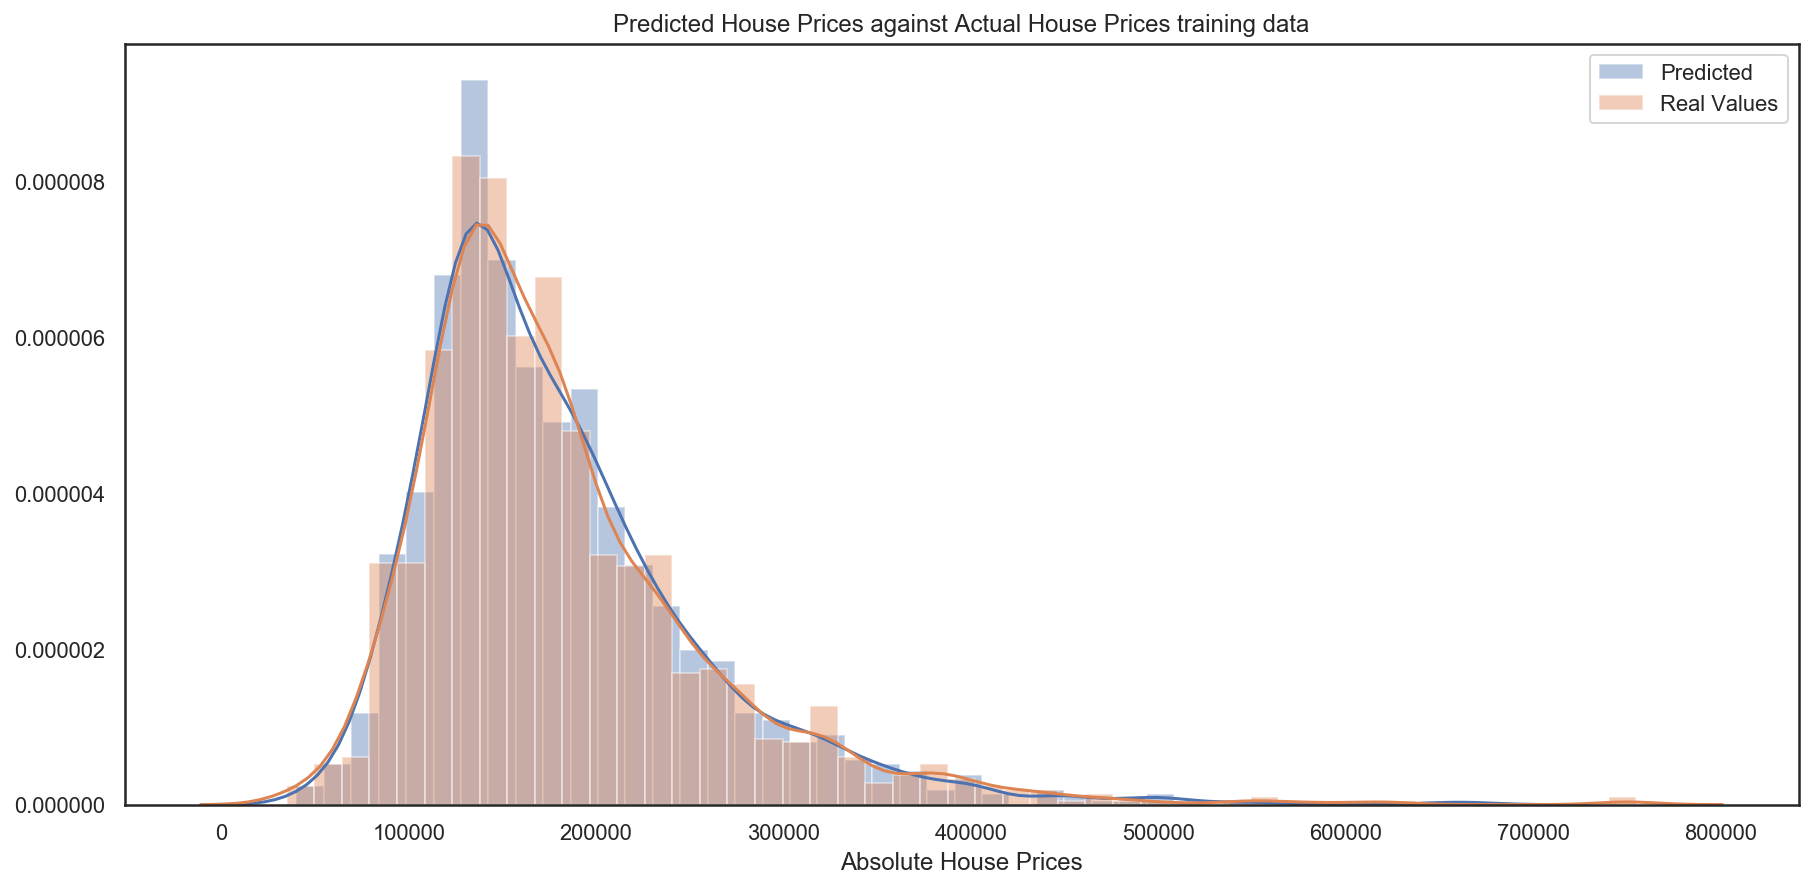

In [303]:
# xtick = range(1,2450000, 20000)
f, ax = plt.subplots(figsize=(15,7))

# ax.xaxis.set_ticks(np.arange(0, 2450000, 500000))

sns.distplot(result_training_set["prediction"])
sns.distplot(result_training_set["actual"])
plt.legend(['Predicted', 'Real Values'])
plt.title("Predicted House Prices against Actual House Prices training data")
plt.xlabel('Absolute House Prices')
# plt.savefig('pred_vs_real.png')

plt.show()

In [304]:
from scipy import stats
import statsmodels.api as sm

est = sm.OLS(y_train, train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     105.5
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:23:53   Log-Likelihood:                 1359.7
No. Observations:                1448   AIC:                            -2319.
Df Residuals:                    1248   BIC:                            -1264.
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
1stFlrSF                 -0.01

In [305]:
# test = test.loc[:, selected_cols].drop("SalePrice", axis =1)
# train = full_train.loc[:, selected_cols].drop("SalePrice", axis =1)

#### Test Prediction

In [313]:
finalMd = (np.expm1(LassoMd.predict(test)) + np.expm1(ENetMd.predict(test)) + np.expm1(KRRMd.predict(test)) + np.expm1(GBoostMd.predict(test)) +
          np.expm1(XG.predict(test)) + np.expm1(LGB.predict(test))) / 6
finalMd

array([122805.61817243, 163095.6185925 , 184518.28430964, ...,
       169088.63968801, 116303.44504207, 218428.53153222])

In [314]:
# test_predictions = XG.predict(test)
# test_predictions = np.expm1(test_predictions)

#### Submission File

In [318]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = finalMd
sub.to_csv('remove_variable_improved_submission.csv',index=False)